In [173]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns

In [174]:
# read data in and take a look at format
curology_df = pd.read_csv('curology_eda_data.csv', sep=',')
curology_df.head()

,customer_id,retention_days,formula_changes,current_formula_type,gender,age
0,10049,68,0,Acne,female,20
1,10127,34,0,Acne,female,19
2,10191,42,2,Acne,male,24
3,10273,115,1,Acne,female,19
4,10282,31,0,Acne,male,18


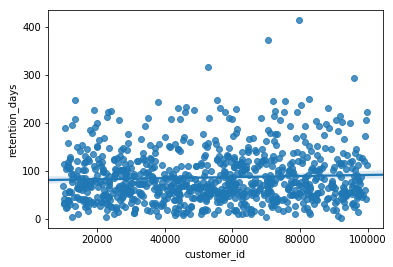

In [175]:
# customer id is sequential, so we have a decent idea which customers came first.
# theory is that earlier customers may have lower retetion days as the product is still being worked on
curology_df.sort_values(by='customer_id', ascending = True, inplace= True)
sns.regplot(x='customer_id', y='retention_days', data=curology_df)

Doesn't look like much of a relationship. Not going to include it

### Modeling time!


In [176]:
# remove extreme outliers for the retention days discovered in EDA
retention_days_cutoff = (curology_df["retention_days"].quantile(0.99))
curology_modeling_df = curology_df[curology_df["retention_days"] < retention_days_cutoff]
curology_modeling_df.describe()

,customer_id,retention_days,formula_changes,age
count,840.000000,840.000000,840.000000,840.000000
mean,53945.115476,84.310714,1.320238,25.302381
std,25494.443492,50.080673,1.129756,9.551641
min,10049.000000,2.000000,0.000000,13.000000
25%,31145.500000,49.000000,0.000000,17.000000
50%,54761.500000,72.000000,1.000000,22.000000
75%,74563.750000,113.000000,2.000000,33.000000
max,99869.000000,244.000000,5.000000,56.000000


In [177]:
# encode categorical variables
curology_modeling_df = pd.get_dummies(curology_modeling_df, columns=['gender','current_formula_type'])
curology_modeling_df.drop('customer_id',axis=1, inplace=True) # could set it as index as well
curology_modeling_df.head()

,retention_days,formula_changes,age,gender_female,gender_male,current_formula_type_Acne,current_formula_type_Anti-Aging,current_formula_type_Balancing
0,68,0,20,1,0,1,0,0
1,34,0,19,1,0,1,0,0
2,42,2,24,0,1,1,0,0
3,115,1,19,1,0,1,0,0
4,31,0,18,0,1,1,0,0


In [178]:
# train / test split

features = curology_modeling_df
# Labels are the values we want to predict
labels = np.array(features['retention_days'])
# Remove the labels from the features
features= features.drop('retention_days', axis = 1)
# Saving feature names for later use
feature_list = list(features.columns)
features = np.array(features)

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = \
train_test_split(features, labels, test_size = 0.25, random_state = 42)

print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (630, 7)
Training Labels Shape: (630,)
Testing Features Shape: (210, 7)
Testing Labels Shape: (210,)


#### Baseline

In [179]:
from math import sqrt
# establish baseline error, if we were just to guess average, what would the results look like?
sqrt(mean_squared_error(test_labels, np.full((test_labels.size), test_labels.mean())))

50.89933175189156

#### Random Forest
Absolutey terrible! Average prediction is off by about 51 days. Lets try to do better with random forest (one of my favorites)

In [180]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rf = RandomForestRegressor(n_estimators = 100, random_state = 1)
rf.fit(train_features, train_labels);
y_train_predicted = rf.predict(train_features)
y_test_predicted = rf.predict(test_features)

rmse_train = sqrt(mean_squared_error(train_labels, y_train_predicted))
rmse_test = sqrt(mean_squared_error(test_labels, y_test_predicted))
print("RF  Train RMSE: {} Test RMSE: {}".format(rmse_train, rmse_test))

RF  Train RMSE: 30.694033334056552 Test RMSE: 45.74327480667668


Training RMSE is a lot lower than testing RMSE, indicating overfitting. Though the RF MSE (45) is still better than baseline (50)

Lets try grid search to get best parameters

In [181]:
n_estimators=[50,150,200,300,500]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [3,5,7]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
grid_param = {'n_estimators': n_estimators,
 'max_features': max_features,
 'max_depth': max_depth,
 'min_samples_split': min_samples_split,
 'min_samples_leaf': min_samples_leaf,
 'bootstrap': bootstrap}

In [182]:
RFR=RandomForestRegressor(random_state=1)
from sklearn.model_selection import GridSearchCV
model = GridSearchCV(estimator=RFR, param_grid=grid_param, n_jobs=-1, cv=5, scoring='neg_mean_squared_error')
model.fit(features, labels)
print(model.best_params_)

{'bootstrap': False, 'max_depth': 3, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}


Awesome, we've got some new parameters to try!

In [183]:
rf = RandomForestRegressor(**model.best_params_)
rf.fit(train_features, train_labels);
y_train_predicted = rf.predict(train_features)
y_test_predicted = rf.predict(test_features)

rmse_train = sqrt(mean_squared_error(train_labels, y_train_predicted))
rmse_test = sqrt(mean_squared_error(test_labels, y_test_predicted))
print("RF  Train RMSE: {} Test RMSE: {}".format(rmse_train, rmse_test))

RF  Train RMSE: 39.491463065100206 Test RMSE: 41.06390079669313


#### Final
This looks much better. Training and test RMSE are way closer than before. 

The predictions are also a lot better, only off by an average of 41 days, versus 45 days from the previous RF and 50 days from guessing.

Feature importances below - I would typically remove low importance features (like acne), but there are so few features that speed is not an issue.

In [184]:
# Get feature importances
importances = list(rf.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:30} Importance: {}'.format(*pair)) for pair in feature_importances[:10]];

Variable: formula_changes                Importance: 0.47
Variable: current_formula_type_Anti-Aging Importance: 0.43
Variable: current_formula_type_Balancing Importance: 0.04
Variable: gender_female                  Importance: 0.02
Variable: gender_male                    Importance: 0.02
Variable: age                            Importance: 0.01
Variable: current_formula_type_Acne      Importance: 0.0
